In [1]:
from asymptotic_complexity_analysis import *
import numpy as np

In [2]:
from bart_playground.bandit.sim_util import LinearScenario, LinearOffsetScenario, OffsetScenario, FriedmanScenario

n_simulations = 36 
n_draws = 1200 

print("Step 1: Creating scenarios...")

# Set a fixed seed for reproducibility
np.random.seed(42)

# Create scenarios
n_arms = 3
n_features = 5
sigma2 = 1.0

scenarios = {
    'Linear': LinearScenario(P=n_features, K=n_arms, sigma2=sigma2),
    'LinearOffset': LinearOffsetScenario(P=n_features, K=n_arms, sigma2=sigma2),
    'Offset': OffsetScenario(P=n_features, K=n_arms, sigma2=sigma2),
    'Friedman': FriedmanScenario(P=n_features, K=n_arms, sigma2=sigma2)
}

Step 1: Creating scenarios...


In [3]:
print("Step 2: Generating simulation data...")
all_scenarios_regrets = generate_simulation_data(scenarios, n_simulations, n_draws)

Step 2: Generating simulation data...

Generating data for Linear scenario...


Simulating: 100%|██████████| 36/36 [1:44:50<00:00, 174.73s/it]



Generating data for LinearOffset scenario...


Simulating: 100%|██████████| 36/36 [2:05:47<00:00, 209.66s/it]



Generating data for Offset scenario...


Simulating: 100%|██████████| 36/36 [2:15:15<00:00, 225.43s/it]



Generating data for Friedman scenario...


Simulating: 100%|██████████| 36/36 [2:05:29<00:00, 209.16s/it]



Step 3: Computing pointwise averages...


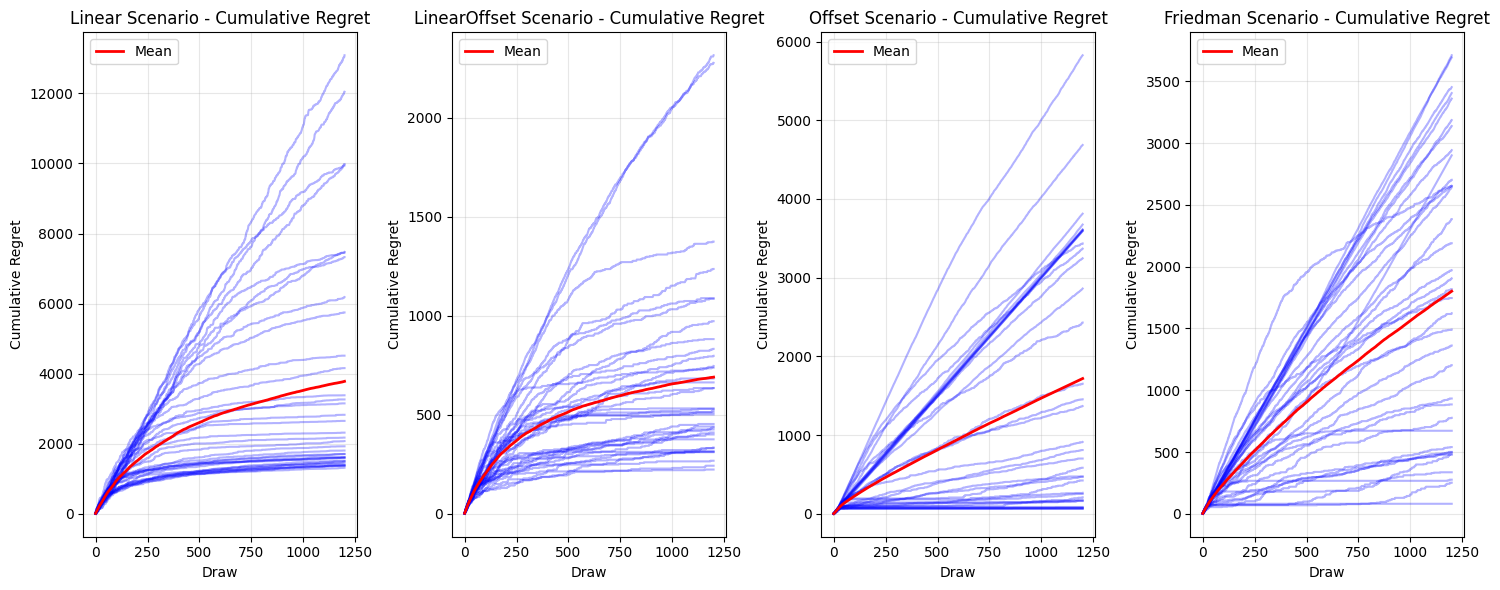

In [4]:
print("\nStep 3: Computing pointwise averages...")
scenario_means = {name: compute_pointwise_average(regrets) for name, regrets in all_scenarios_regrets.items()}

# Plot the raw results
raw_save_path = './results/complexity/regret_curves_raw.png'
plot_scenario_results(all_scenarios_regrets, scenario_means, n_simulations, raw_save_path)

In [5]:
print("\nStep 4: Smoothing and analyzing asymptotic complexity...")
# Define number of points to use for asymptotic analysis
min_points = (2.0/3 * n_draws)  # 2/3 of the total draws
# convert to int
min_points = int(min_points)

complexity_results = analyze_asymptotic_complexity(
    all_scenarios_regrets, 
    scenario_means,
    smoothing_method='gaussian',
    growth_model='both',
    plot=False,
    min_points=min_points
)


Step 4: Smoothing and analyzing asymptotic complexity...

Analyzing asymptotic complexity for Linear scenario...

Analyzing asymptotic complexity for LinearOffset scenario...

Analyzing asymptotic complexity for Offset scenario...

Analyzing asymptotic complexity for Friedman scenario...



Step 5: Creating visualization of asymptotic complexity analysis...


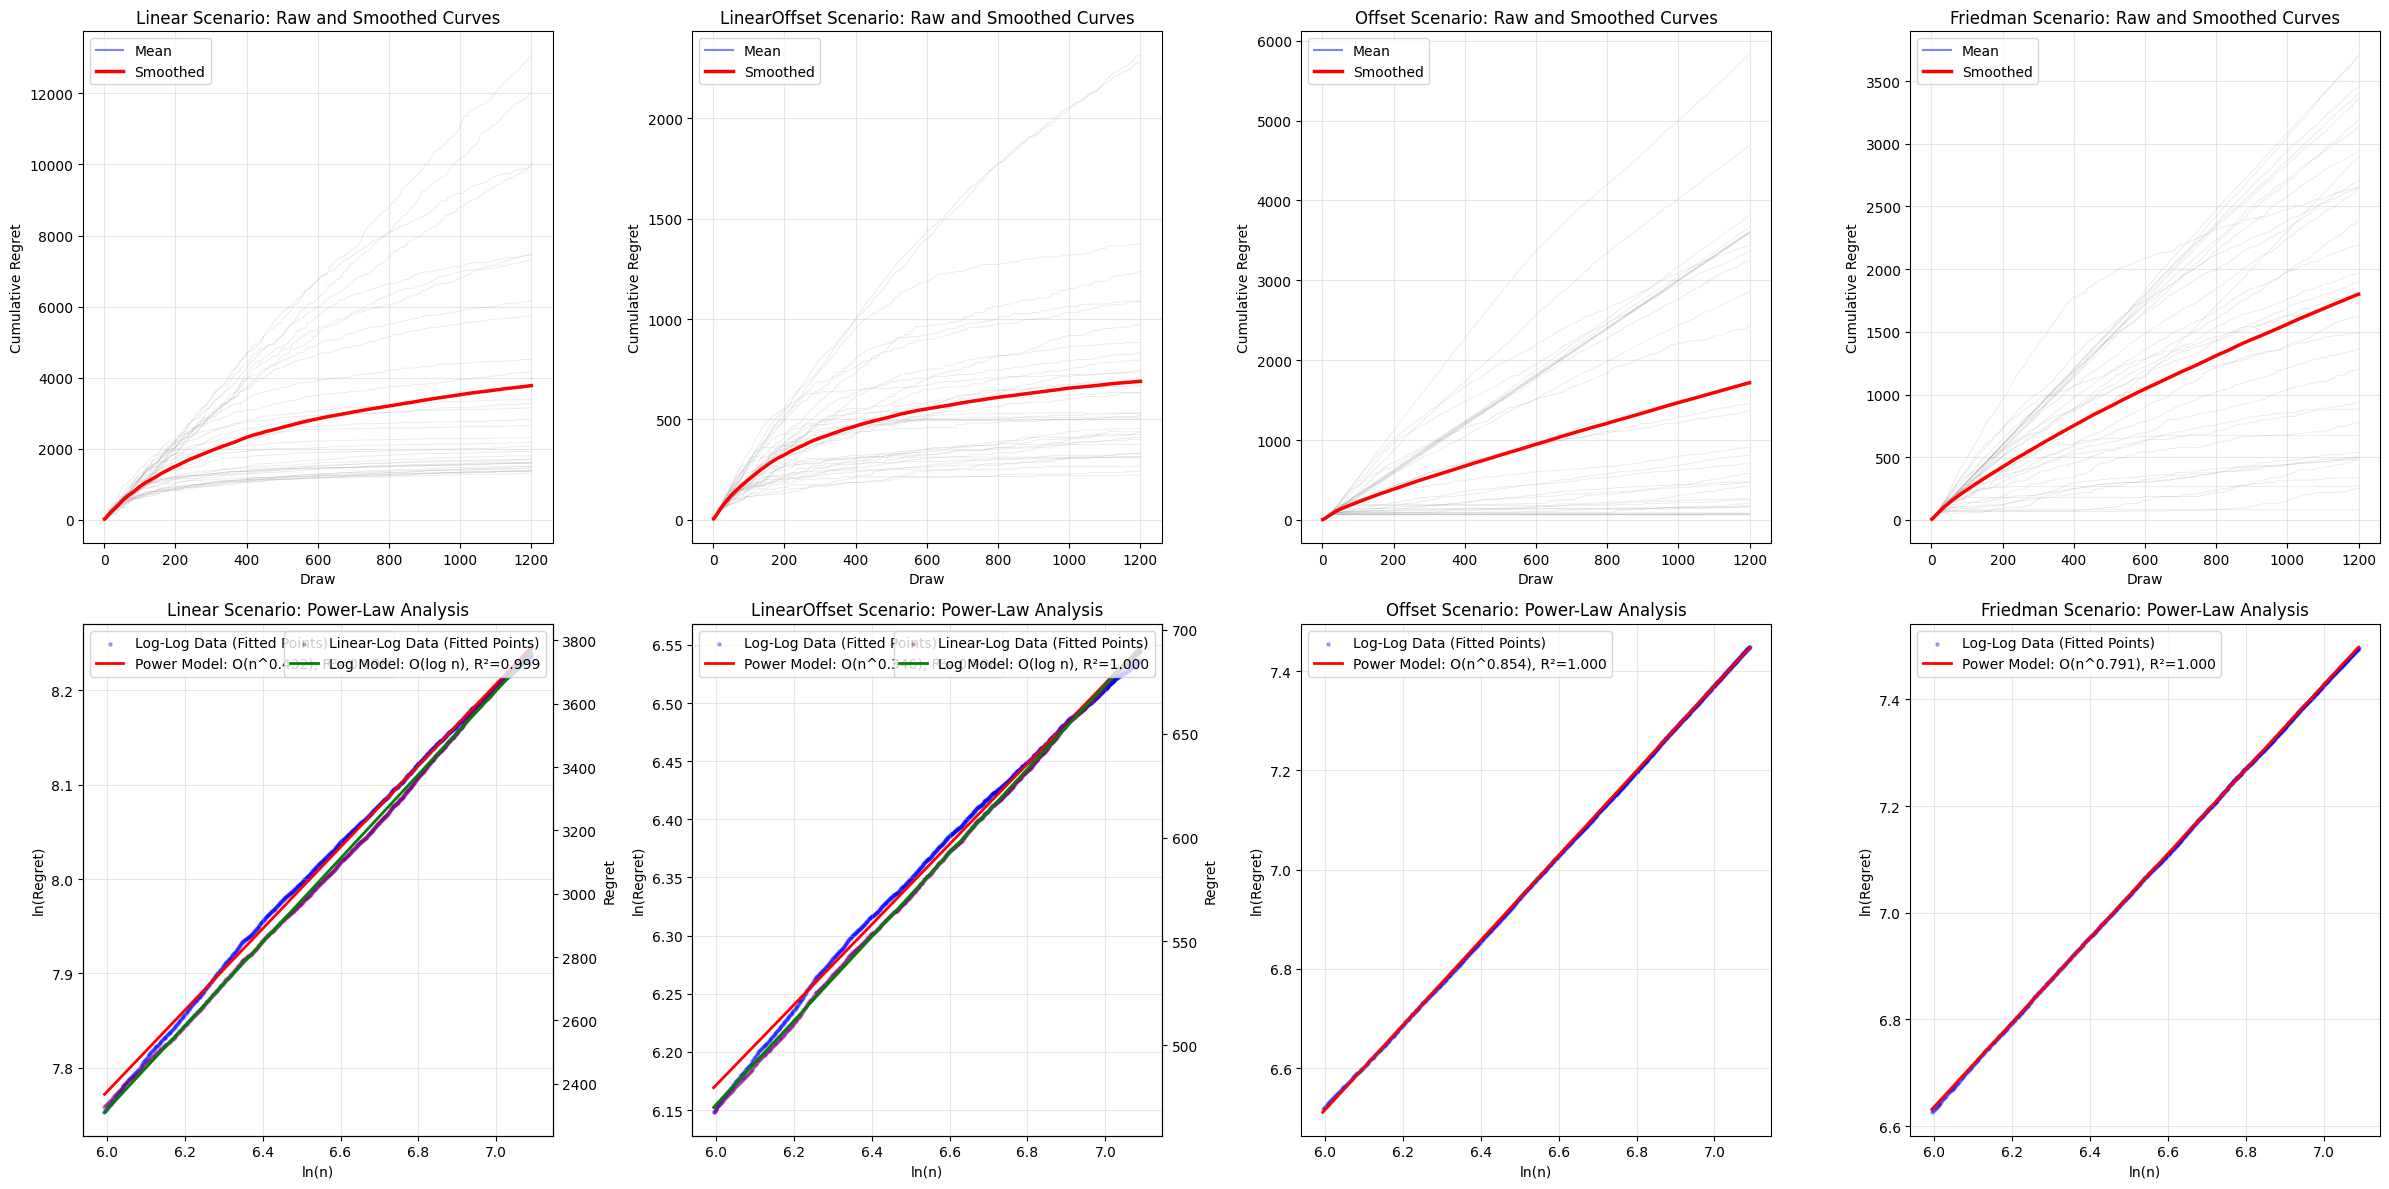

In [6]:
# Step 5: Visualization with smoothing and regression analysis
print("\nStep 5: Creating visualization of asymptotic complexity analysis...")
complexity_viz_path = './results/complexity/asymptotic_complexity_analysis.png'
plot_complexity_analysis(
    complexity_results,
    all_scenarios_regrets,
    scenario_means,
    n_simulations,
    save_path=complexity_viz_path,
    min_points=min_points
)

In [7]:
print("\nAnalysis complete! Summary of results:")
for scenario, result in complexity_results.items():
    growth = result['growth_results']
    best_model = growth.get('best_model', 'Unknown')
    
    print(f"\n{scenario} Scenario:")
    print(f"  - Best fitting model: {best_model}")
    
    # Power-law model
    power_model = growth.get('power', {})
    if power_model:
        print(f"  - Power-law model:")
        print(f"    * Complexity: {power_model.get('big_o', 'Unknown')}")
        print(f"    * Exponent: {power_model.get('exponent', 'N/A'):.4f}")
        print(f"    * R-squared: {power_model.get('r_squared', 'N/A'):.4f}")
        print(f"    * AIC: {power_model.get('aic', 'N/A'):.4f}")
    
    # Logarithmic model
    log_model = growth.get('log', {})
    if log_model:
        print(f"  - Logarithmic model:")
        print(f"    * Complexity: {log_model.get('big_o', 'Unknown')}")
        print(f"    * Slope: {log_model.get('slope', 'N/A'):.4f}")
        print(f"    * R-squared: {log_model.get('r_squared', 'N/A'):.4f}")
        print(f"    * AIC: {log_model.get('aic', 'N/A'):.4f}")


Analysis complete! Summary of results:

Linear Scenario:
  - Best fitting model: log
  - Power-law model:
    * Complexity: O(n^0.432)
    * Exponent: 0.4324
    * R-squared: 0.9982
    * AIC: 4467.7601
  - Logarithmic model:
    * Complexity: O(log(n))
    * Slope: 1324.2723
    * R-squared: 0.9992
    * AIC: 3879.3711

LinearOffset Scenario:
  - Best fitting model: log
  - Power-law model:
    * Complexity: O(n^0.346)
    * Exponent: 0.3457
    * R-squared: 0.9964
    * AIC: 2067.0726
  - Logarithmic model:
    * Complexity: O(log(n))
    * Slope: 201.9653
    * R-squared: 0.9998
    * AIC: -55.4425

Offset Scenario:
  - Best fitting model: power
  - Power-law model:
    * Complexity: O(n^0.854)
    * Exponent: 0.8544
    * R-squared: 1.0000
    * AIC: 1087.0932
  - Logarithmic model:
    * Complexity: O(log(n))
    * Slope: 971.0163
    * R-squared: 0.9846
    * AIC: 5796.1388

Friedman Scenario:
  - Best fitting model: power
  - Power-law model:
    * Complexity: O(n^0.791)
    * 

In [8]:
import pickle
with open("./results/complexity/temp.pkl", "wb") as file:
    pickle.dump((all_scenarios_regrets, scenario_means, complexity_results), file)